In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from ott.geometry.geometry import Geometry
from ott.geometry import pointcloud
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein
from ott.solvers.linear import sinkhorn

from lower_bound import histogram_distances

In [3]:
# Samples spiral
def sample_spiral(
    n, min_radius, max_radius, key, min_angle=0, max_angle=10, noise=1.0
):
    radius = jnp.linspace(min_radius, max_radius, n)
    angles = jnp.linspace(min_angle, max_angle, n)
    data = []
    noise = jax.random.normal(key, (2, n)) * noise
    for i in range(n):
        x = (radius[i] + noise[0, i]) * jnp.cos(angles[i])
        y = (radius[i] + noise[1, i]) * jnp.sin(angles[i])
        data.append([x, y])
    data = jnp.array(data)
    return data


# Samples Swiss roll
def sample_swiss_roll(
    n, min_radius, max_radius, length, key, min_angle=0, max_angle=10, noise=0.1
):
    spiral = sample_spiral(
        n, min_radius, max_radius, key[0], min_angle, max_angle, noise
    )
    third_axis = jax.random.uniform(key[1], (n, 1)) * length
    swiss_roll = jnp.hstack((spiral[:, 0:1], third_axis, spiral[:, 1:]))
    return swiss_roll


# Plots spiral and Swiss roll
def plot(
    swiss_roll, spiral, colormap_angles_swiss_roll, colormap_angles_spiral
):
    fig = plt.figure(figsize=(11, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(spiral[:, 0], spiral[:, 1], c=colormap_angles_spiral)
    ax.grid()
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.view_init(7, -80)
    ax.scatter(
        swiss_roll[:, 0],
        swiss_roll[:, 1],
        swiss_roll[:, 2],
        c=colormap_angles_swiss_roll,
    )
    ax.set_adjustable("box")
    plt.show()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


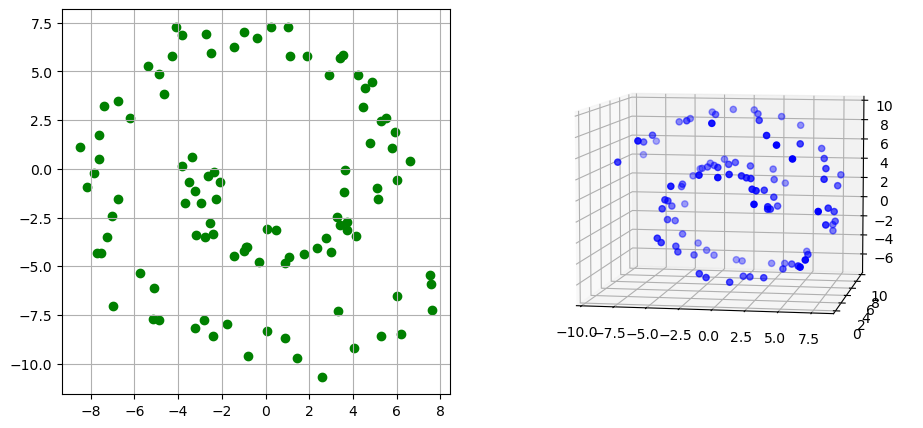

In [4]:
# Data parameters
n_spiral = 100
n_swiss_roll = 100
length = 10
min_radius = 3
max_radius = 10
noise = 0.8
min_angle = 0
max_angle = 9
angle_shift = 3

# Seed
seed = 14
key = jax.random.PRNGKey(seed)
key, *subkey = jax.random.split(key, 4)

spiral = sample_spiral(
    n_spiral,
    min_radius,
    max_radius,
    key=subkey[0],
    min_angle=min_angle + angle_shift,
    max_angle=max_angle + angle_shift,
    noise=noise,
)
swiss_roll = sample_swiss_roll(
    n_swiss_roll,
    min_radius,
    max_radius,
    key=subkey[1:],
    length=length,
    min_angle=min_angle,
    max_angle=max_angle,
)

plot(swiss_roll, spiral, "blue", "green")

In [10]:
# apply Gromov-Wasserstein
geom_xx = pointcloud.PointCloud(x=spiral, y=spiral)
geom_yy = pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)
prob = quadratic_problem.QuadraticProblem(geom_xx, geom_yy)

solver = gromov_wasserstein.GromovWasserstein(epsilon=100.0, max_iterations=20)
out = solver(prob)

n_outer_iterations = jnp.sum(out.costs != -1)
has_converged = bool(out.linear_convergence[n_outer_iterations - 1])
print(f"{n_outer_iterations} outer iterations were needed.")
print(f"The last Sinkhorn iteration has converged: {has_converged}")
print(f"The outer loop of Gromov Wasserstein has converged: {out.converged}")
print(f"The final regularized GW cost is: {out.reg_gw_cost:.3f}")

7 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 1170.657


In [18]:
# Input to the SLB should be a `QuadraticProblem`
# prob

def pairwise_dists(point_cloud : pointcloud.PointCloud, squared = False):
    norms = jnp.sum(jnp.square(point_cloud.x), axis = 1)
    dists_sq = jnp.maximum(norms[:, None] + norms[None, :] - 2 * point_cloud.x @ point_cloud.x.T, 0)
    if squared:
        return dists_sq
    else:
        return jnp.sqrt(dists_sq)


# xx_dists = pairwise_dists(geom_xx)
# yy_dists = pairwise_dists(geom_yy)
distance_fn = jax.jit(histogram_distances)
xy_dist = distance_fn(geom_xx, geom_yy)

geom_xy = Geometry(cost_matrix=xy_dist, epsilon = .5)
solve_fn = jax.jit(sinkhorn.solve)
ot = solve_fn(geom_xy)

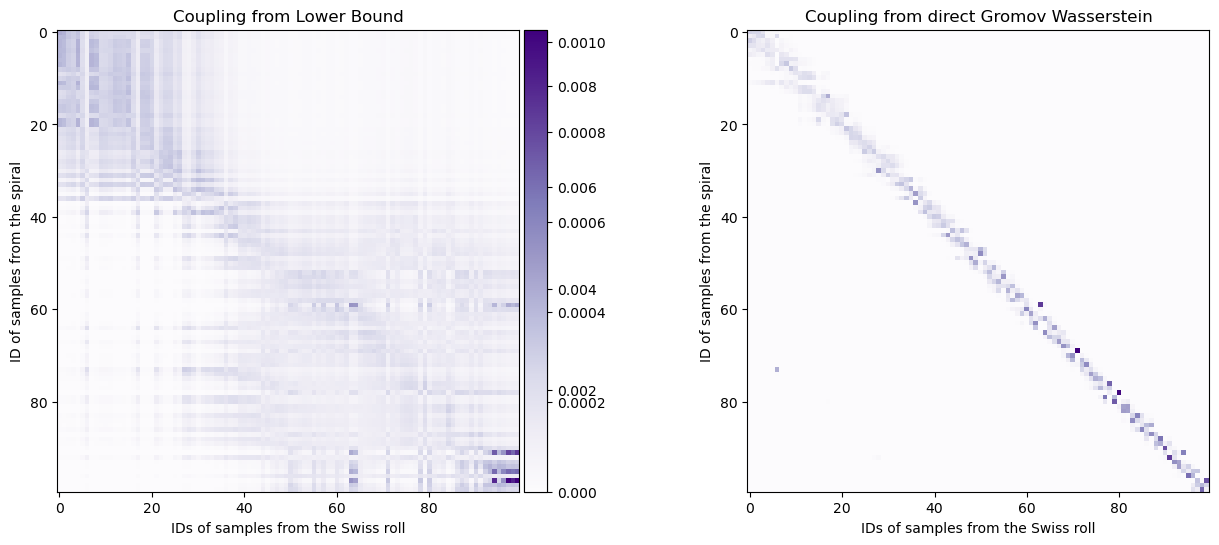

In [14]:
ot = solve_fn(geom_xy)

transport_lowerbound = ot.matrix
transport_gw = out.matrix
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
f = axs[0].imshow(transport_lowerbound, cmap="Purples")
axs[0].set(ylabel =
    "ID of samples from the spiral", 
    xlabel = "IDs of samples from the Swiss roll",
    title = "Coupling from Lower Bound"
    # fontsize=14
)  # IDs are ordered from center to outer part
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(f, cax=cax, orientation = 'vertical')

f = axs[1].imshow(transport_gw, cmap="Purples")
axs[1].set(ylabel =
    "ID of samples from the spiral", 
    xlabel = "IDs of samples from the Swiss roll",
    title = "Coupling from direct Gromov Wasserstein"
    # fontsize=14
)  # IDs are ordered from center to outer part
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(f, cax=cax, orientation = 'vertical')

plt.show()
# xy_dist
# xx_dists[-1]
# yy_dists[1]

In [88]:
# np.sum(xx_dists, axis = 1)
ot.primal_cost

out.primal_cost

Array(865.68225, dtype=float32)